In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
import time
import pyepo
import torch
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use("science")
import numpy as np
from tqdm import tqdm
torch.manual_seed(135)

Auto-Sklearn cannot be imported.


## Init Data

In [3]:
# generate data for grid network (features and costs)
m = 48 # number of items
n = 100 # number of data
p = 5 # size of feature
deg = 4 # polynomial degree
dim = 2 # dimension of knapsack
noise_width = 0.5 # noise half-width
caps = [30] * dim # capacity
weights, x, c = pyepo.data.knapsack.genData(n+1000, p, m, deg=deg, dim=dim, noise_width=noise_width)

In [4]:
weights

array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7.83, 5.64, 7.56, 3.28, 4.31, 3.85, 6.43, 4.26, 7.56, 6.4 , 6.09,
        6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27, 4.55,
        5.64, 5.66, 3.27, 6.68],
       [4.2 , 5.61, 6.13, 7.88, 4.61, 4.92, 6.09, 7.95, 7.11, 4.02, 3.07,
        7.84, 6.29, 5.78, 5.57, 5.65, 7.41, 5.21, 3.42, 6.48, 5.77, 7.67,
        7.32, 3.31, 4.36, 4.75, 3.38, 3.44, 6.3 , 4.85, 7.09, 5.7 , 4.05,
        6.04, 6.51, 3.41, 7.94, 6.05, 7.18, 3.64, 4.35, 4.45, 4.27, 4.87,
        5.74, 3.16, 5.41, 3.81]])

## Optimization Model 

In [5]:
ks_model = pyepo.model.grb.knapsackModel(weights, caps)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-03-06


In [6]:
# solve
ks_model.setObj([i for i in range(m)])
sol, obj = ks_model.solve()
print(sol)
print("Obj: {}".format(obj))
for i in ks_model.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Obj: 265.0
40
43
44
45
46
47


In [7]:
# relax
ks_model_rel = ks_model.relax()

In [8]:
# solve
ks_model_rel.setObj([i for i in range(m)])
sol, obj = ks_model_rel.solve()
print(sol)
print("Obj: {}".format(obj))
for i in ks_model_rel.items:
    if sol[i] > 1e-3:
        print(i)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9225932025752352, 0.0, 0.0, 1.0, 0.6333283425662526, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]
Obj: 281.10241054050005
37
40
41
43
45
46
47


## Data Loader 

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

In [10]:
# data split
x_train, x_test, c_train, c_test = train_test_split(x, c, test_size=1000, random_state=246)

In [11]:
# get training data set
ks_dataset_train = pyepo.data.dataset.optDataset(ks_model, x_train, c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 214.54it/s]


In [12]:
# get training data set for relaxation
ks_dataset_train_rel = pyepo.data.dataset.optDataset(ks_model_rel, x_train, c_train)

Optimizing for optDataset...


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 877.00it/s]


In [13]:
# get test data set
ks_dataset_test = pyepo.data.dataset.optDataset(ks_model, x_test, c_test)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 234.31it/s]


In [14]:
# get data loader
batch_size = 32
ks_loader_train = DataLoader(ks_dataset_train, batch_size=batch_size, shuffle=True)
ks_loader_train_rel = DataLoader(ks_dataset_train_rel, batch_size=batch_size, shuffle=True)
ks_loader_test = DataLoader(ks_dataset_test, batch_size=batch_size, shuffle=False)

In [15]:
for i, data in enumerate(ks_loader_train):
    x, c, w, z = data
    break

In [16]:
x.shape

torch.Size([32, 5])

In [17]:
c.shape

torch.Size([32, 48])

In [18]:
w.shape

torch.Size([32, 48])

In [19]:
z.shape

torch.Size([32, 1])

## Linear Regression from Scikit-Lear 

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
# prediction model
reg = LinearRegression()

## Two-Stage 

In [22]:
# build model
twostage_model = pyepo.twostage.sklearnPred(reg)

In [23]:
# training
twostage_model.fit(ks_dataset_train.feats, ks_dataset_train.costs)

MultiOutputRegressor(estimator=LinearRegression())

In [24]:
# prediction
c_test_pred = twostage_model.predict(ks_dataset_test.feats)

In [25]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += pyepo.metric.calRegret(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.metric.calUnambRegret(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print("Normalized true SPO Loss: {:.2f}%".format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print("Normalized unambiguous SPO Loss: {:.2f}%".format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.48it/s]


Normalized true SPO Loss: 12.45%
Normalized unambiguous SPO Loss: 12.45%


In [26]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    # predict
    cp = twostage_model.predict(x)
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: 1.53, 4.22, 1.01, 0.43, 1.73, 0.37, 1.77, 1.53, 0.90, 1.17, 4.08, 1.57, 0.99, 4.51, 2.95, 1.91, 1.86, 1.74, 3.12, 2.99, 1.30, 0.98, 1.57, 0.53, 3.14, 2.77, 2.31, 3.00, 1.26, 1.70, 1.55, 1.49, 3.77, 1.11, 3.58, 3.87, 1.37, 3.00, 3.01, 1.12, 1.64, 3.89, 1.39, 3.84, 2.86, 1.17, 3.84, 1.32
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0

## Two-Stage with Grid Search 

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [28]:
# build model
twostage_model = pyepo.twostage.sklearnPred(Ridge())

In [29]:
# creat scorer
spo_scorer = pyepo.metric.metrics.makeSkScorer(ks_model)

In [30]:
# build grid search
grid = GridSearchCV(twostage_model, param_grid={"estimator__alpha": [0, 0.1, 0.5]}, scoring=spo_scorer)

In [31]:
# training
grid.fit(ks_dataset_train.feats, ks_dataset_train.costs)

GridSearchCV(estimator=MultiOutputRegressor(estimator=Ridge()),
             param_grid={"estimator__alpha": [0, 0.1, 0.5]},
             scoring=make_scorer(SPOError, greater_is_better=False, model_type=<class "pyepo.model.grb.knapsack.knapsackModel">, args={"weights": array([[4.59, 4.87, 5.19, 7.59, 6.8 , 4.97, 4.84, 3.22, 7.9 , 3.62, 3.12,
        6.81, 7.09, 3.23, 4.47, 5.23, 6.11, 5.23, 4.27, 6.66, 5.21, 3.72,
        7.83, 5.64, 7.56, 3.28, 4.31, 3.85, 6.43, 4.26, 7.56, 6.4 , 6.09,
        6.4 , 4.5 , 6.31, 6.35, 3.07, 6.03, 7.39, 3.48, 5.57, 6.27, 4.55,
        5.64, 5.66, 3.27, 6.68],
       [4.2 , 5.61, 6.13, 7.88, 4.61, 4.92, 6.09, 7.95, 7.11, 4.02, 3.07,
        7.84, 6.29, 5.78, 5.57, 5.65, 7.41, 5.21, 3.42, 6.48, 5.77, 7.67,
        7.32, 3.31, 4.36, 4.75, 3.38, 3.44, 6.3 , 4.85, 7.09, 5.7 , 4.05,
        6.04, 6.51, 3.41, 7.94, 6.05, 7.18, 3.64, 4.35, 4.45, 4.27, 4.87,
        5.74, 3.16, 5.41, 3.81]]), "capacity": array([30, 30])}))

In [32]:
# prediction
c_test_pred = grid.predict(ks_dataset_test.feats)

In [33]:
# evaluate
truespo = 0
unambspo = 0
for i in tqdm(range(1000)):
    c_pred_i = c_test_pred[i]
    c_true_i = ks_dataset_test.costs[i]
    z_true_i = ks_dataset_test.objs[i,0]
    truespo += pyepo.metric.calRegret(ks_model, c_pred_i, c_true_i, z_true_i)
    unambspo += pyepo.metric.calUnambRegret(ks_model, c_pred_i, c_true_i, z_true_i)
time.sleep(1)
print("Normalized true SPO Loss: {:.2f}%".format(truespo / abs(ks_dataset_test.objs.sum()) * 100))
print("Normalized unambiguous SPO Loss: {:.2f}%".format(unambspo / abs(ks_dataset_test.objs.sum()) * 100))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.91it/s]


Normalized true SPO Loss: 12.45%
Normalized unambiguous SPO Loss: 12.45%


In [34]:
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    # predict
    cp = grid.predict(x)
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: 1.53, 4.22, 1.01, 0.43, 1.73, 0.37, 1.77, 1.53, 0.90, 1.17, 4.08, 1.57, 0.99, 4.51, 2.95, 1.91, 1.86, 1.74, 3.12, 2.99, 1.30, 0.98, 1.57, 0.53, 3.14, 2.77, 2.31, 3.00, 1.26, 1.70, 1.55, 1.49, 3.77, 1.11, 3.58, 3.87, 1.37, 3.00, 3.01, 1.12, 1.64, 3.89, 1.39, 3.84, 2.86, 1.17, 3.84, 1.32
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0

## Linear Regression from PyTorch

In [35]:
from torch import nn

In [36]:
# build linear model
class LinearRegression(nn.Module):
    
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(p, m)
    
    def forward(self, x):
        out = self.linear(x)
        return out

## SPO+ 

In [37]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [38]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [39]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(ks_model, processes=4)

Num of cores: 4


In [40]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  52.7768, True SPO Loss: 41.3722%, Unambiguous SPO Loss: 41.3722%
Epoch  20, Loss:  25.7325, True SPO Loss: 34.7294%, Unambiguous SPO Loss: 34.7294%
Epoch  30, Loss:  63.8126, True SPO Loss: 29.9129%, Unambiguous SPO Loss: 29.9129%
Epoch  40, Loss:  39.6705, True SPO Loss: 24.7166%, Unambiguous SPO Loss: 24.7166%
Epoch  50, Loss:  35.9990, True SPO Loss: 21.5548%, Unambiguous SPO Loss: 21.5548%
Epoch  60, Loss:  51.8161, True SPO Loss: 18.5789%, Unambiguous SPO Loss: 18.5789%
Epoch  70, Loss:  20.9964, True SPO Loss: 16.6596%, Unambiguous SPO Loss: 16.6596%
Epoch  80, Loss:  14.5626, True SPO Loss: 15.6616%, Unambiguous SPO Loss: 15.6616%
Epoch  90, Loss:  29.5003, True SPO Loss: 14.7383%, Unambiguous SPO Loss: 14.7383%
Epoch 100, Loss:  31.5685, True SPO Loss: 13.9726%, Unambiguous SPO Loss: 13.9726%
Epoch 110, Loss:  51.4157, True SPO Loss: 13.4251%, Unambiguous SPO Loss: 13.4251%
Epoch 120, Loss:  43.5283, True SPO Loss: 13.4069%, Unambiguous SPO Loss: 13.4069%
Epoc

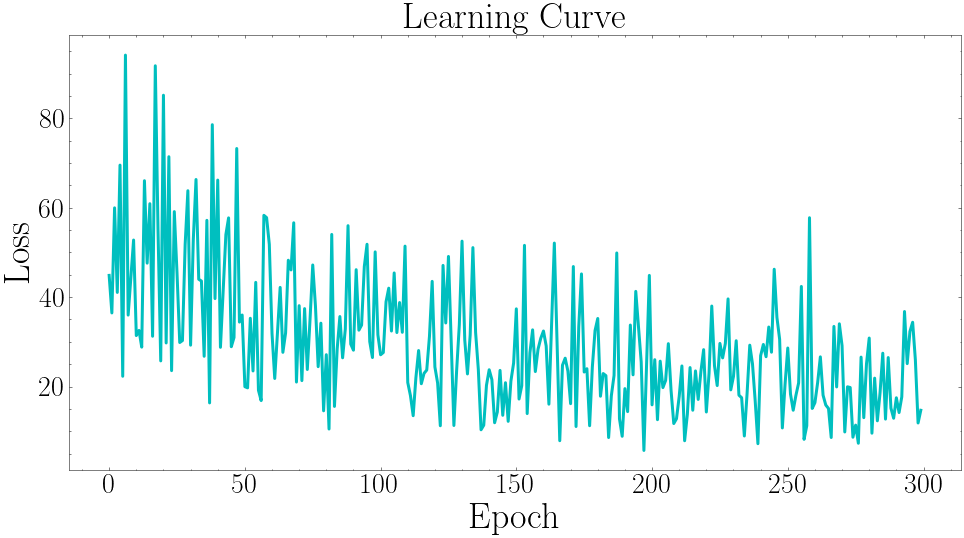

In [41]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

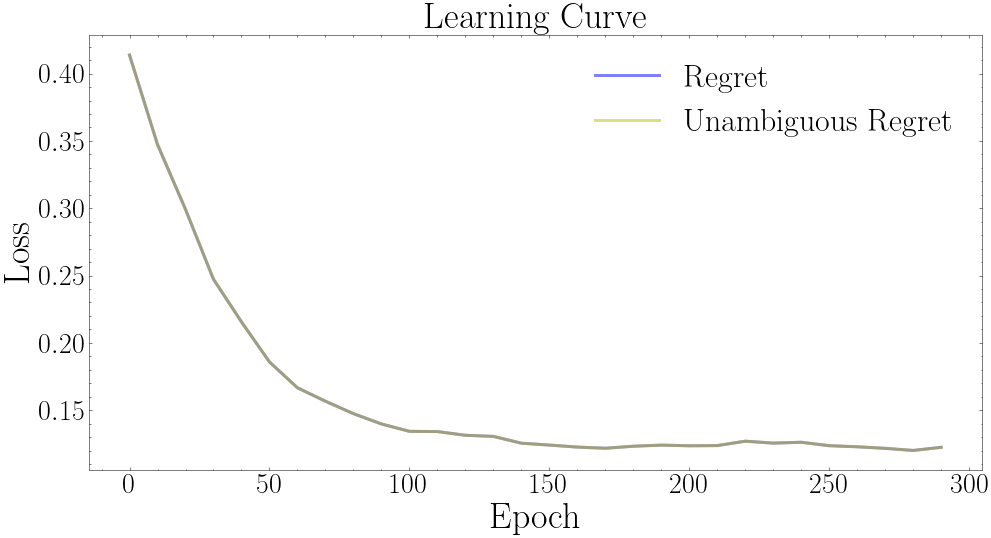

In [42]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color="b", alpha=0.5, lw=3, label="Regret")
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color="y", alpha=0.5, lw=3, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [43]:
# evaluate
spoloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
print("Normalized true SPO Loss: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
print("Normalized unambiguous SPO Loss: {:.2f}%".format(spoloss * 100))

Normalized true SPO Loss: 12.24%
Normalized unambiguous SPO Loss: 12.24%


In [44]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(-cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(-cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(-z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(-zpj))
        print()
    break

Sample 0:
    True cost: -2.00, -4.00, -1.00, -1.00, -2.00, -1.00, -2.00, -1.00, -1.00, -2.00, -5.00, -1.00, -1.00, -5.00, -3.00, -2.00, -1.00, -2.00, -3.00, -3.00, -1.00, -1.00, -1.00, -1.00, -3.00, -3.00, -2.00, -2.00, -1.00, -2.00, -2.00, -2.00, -3.00, -1.00, -4.00, -2.00, -1.00, -3.00, -4.00, -1.00, -2.00, -4.00, -1.00, -2.00, -3.00, -1.00, -5.00, -2.00
    Pred cost: -1.10, -3.36, 0.02, -0.99, -0.71, 0.52, -1.34, -0.97, -0.30, -0.17, -3.37, -1.31, -0.54, -3.25, -2.39, -0.78, -1.88, 0.07, -1.95, -1.89, -0.85, 0.22, -0.44, 0.75, -2.25, -2.33, -1.58, -2.33, -0.89, -1.23, -1.59, -0.56, -2.94, -1.10, -2.51, -2.82, -1.18, -1.97, -2.07, -0.09, -1.11, -2.69, -0.58, -2.63, -1.83, -0.48, -3.25, -0.35
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: -27.00
    Pred sol: -0, -0, 0, -0, -0, 0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, 0

## SPO+ Rel 

In [45]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [46]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [47]:
# init SPO+ loss
criterion = pyepo.func.SPOPlus(ks_model_rel, processes=4)

Num of cores: 4


In [48]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train_rel):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # forward pass
        cp = reg(x)
        loss = criterion.apply(cp, c, w, z).mean()
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  36.2603, True SPO Loss: 42.2228%, Unambiguous SPO Loss: 42.2228%
Epoch  20, Loss:  67.2592, True SPO Loss: 33.0242%, Unambiguous SPO Loss: 33.0242%
Epoch  30, Loss:  23.6781, True SPO Loss: 27.1330%, Unambiguous SPO Loss: 27.1330%
Epoch  40, Loss:  40.0967, True SPO Loss: 21.3286%, Unambiguous SPO Loss: 21.3286%
Epoch  50, Loss:  45.7020, True SPO Loss: 19.4295%, Unambiguous SPO Loss: 19.4295%
Epoch  60, Loss:  76.4368, True SPO Loss: 17.8475%, Unambiguous SPO Loss: 17.8475%
Epoch  70, Loss:  47.6374, True SPO Loss: 16.5182%, Unambiguous SPO Loss: 16.5182%
Epoch  80, Loss:  31.4404, True SPO Loss: 16.1060%, Unambiguous SPO Loss: 16.1060%
Epoch  90, Loss:  37.1449, True SPO Loss: 16.0232%, Unambiguous SPO Loss: 16.0232%
Epoch 100, Loss:  15.9022, True SPO Loss: 14.9524%, Unambiguous SPO Loss: 14.9524%
Epoch 110, Loss:  45.5765, True SPO Loss: 14.2130%, Unambiguous SPO Loss: 14.2170%
Epoch 120, Loss:  34.5213, True SPO Loss: 13.8311%, Unambiguous SPO Loss: 13.8311%
Epoc

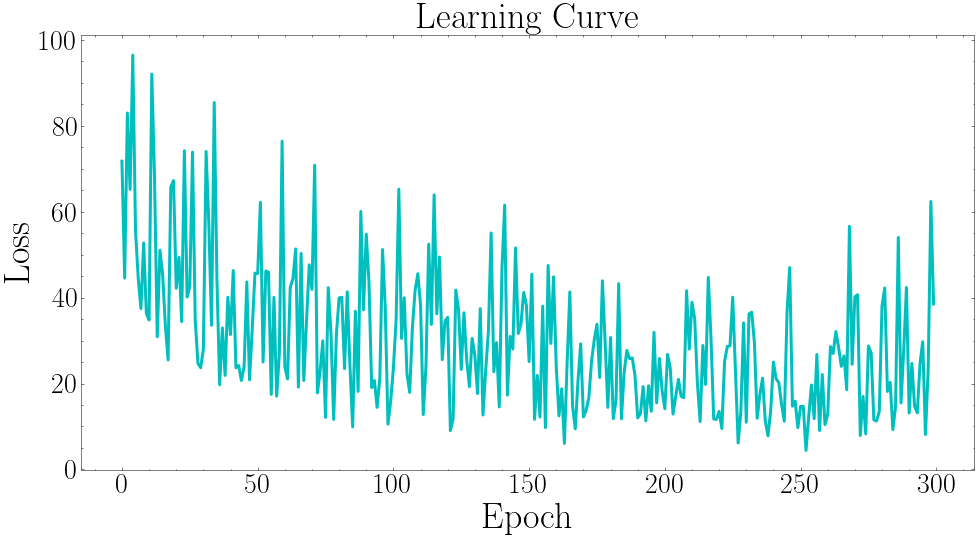

In [49]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

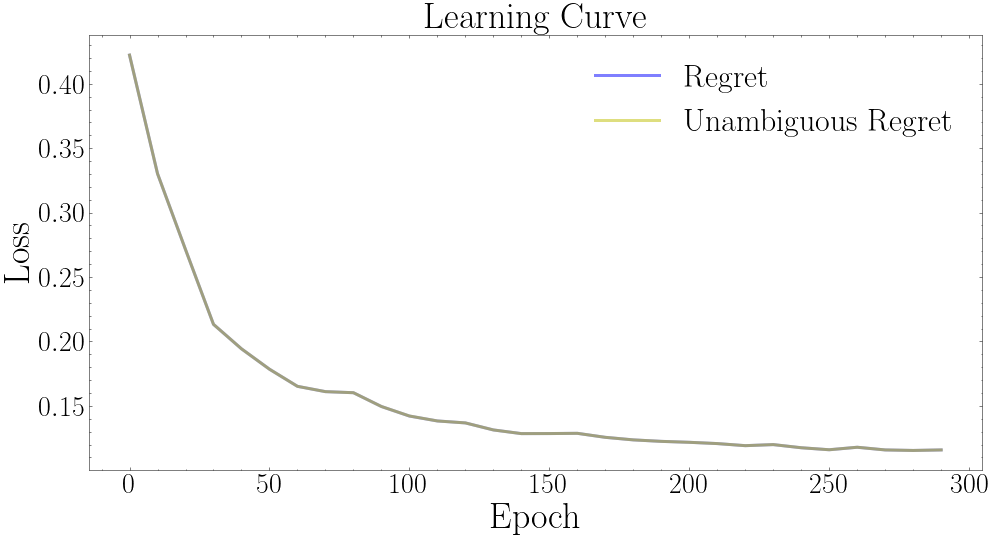

In [50]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color="b", alpha=0.5, lw=3, label="Regret")
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color="y", alpha=0.5, lw=3, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [51]:
# evaluate
spoloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
print("Normalized true SPO Loss: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
print("Normalized unambiguous SPO Loss: {:.2f}%".format(spoloss * 100))

Normalized true SPO Loss: 11.58%
Normalized unambiguous SPO Loss: 11.58%


In [52]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: 0.59, 3.06, -0.22, 0.24, 1.41, -0.77, 1.18, -0.58, 1.12, 0.09, 3.46, -1.22, 0.08, 3.36, 2.49, 0.59, 1.36, 0.81, 2.22, 1.51, 0.40, 0.21, 0.90, -0.33, 2.71, 1.90, 1.53, 2.10, 1.26, 0.84, 0.68, 0.62, 2.50, 0.23, 2.46, 2.53, 0.25, 1.85, 2.10, 0.32, 0.99, 2.90, 0.35, 2.56, 1.47, 0.15, 2.94, 0.63
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: -0, 0, 0, -0, -0, 0, -0, 0, -0, -0, 1, 0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, 0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0,

## Black-Box

In [53]:
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [54]:
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=1e-2)

In [55]:
# set loss
bb = pyepo.func.blackboxOpt(ks_model, lambd=20, processes=4)
criterion = nn.L1Loss()

Num of cores: 4


In [56]:
# train model
num_epochs = 300
reg.train()
loss_log = []
loss_log_truespo = []
loss_log_unambspo = []
for epoch in range(num_epochs):
    # load data
    for i, data in enumerate(ks_loader_train):
        x, c, w, z = data
        # cuda
        if torch.cuda.is_available():
            x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
        # linear regression
        cp = reg(x)
        # black-box optimizer
        wp = bb.apply(cp)
        # objective value
        zp = (wp * c).sum(1).view(-1, 1)
        # loss
        loss = criterion(zp, z)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_log.append(loss.item())
    if (epoch + 1) % 10 == 0:
        # true SPO
        trueloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
        loss_log_truespo.append(trueloss)
        # unambiguous SPO 
        unambloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
        loss_log_unambspo.append(unambloss)
        print("Epoch {:3}, Loss: {:8.4f}, True SPO Loss: {:7.4f}%, Unambiguous SPO Loss: {:7.4f}%". \
              format(epoch+1, loss.item(), trueloss*100, unambloss*100))

Epoch  10, Loss:  13.7500, True SPO Loss: 43.2976%, Unambiguous SPO Loss: 43.2976%
Epoch  20, Loss:  24.7500, True SPO Loss: 38.4710%, Unambiguous SPO Loss: 38.4710%
Epoch  30, Loss:   7.7500, True SPO Loss: 33.8829%, Unambiguous SPO Loss: 33.8829%
Epoch  40, Loss:  17.5000, True SPO Loss: 29.8442%, Unambiguous SPO Loss: 29.8442%
Epoch  50, Loss:  12.0000, True SPO Loss: 26.6016%, Unambiguous SPO Loss: 26.6016%
Epoch  60, Loss:  18.2500, True SPO Loss: 24.7752%, Unambiguous SPO Loss: 24.7752%
Epoch  70, Loss:  17.2500, True SPO Loss: 22.9630%, Unambiguous SPO Loss: 22.9630%
Epoch  80, Loss:  10.5000, True SPO Loss: 21.7953%, Unambiguous SPO Loss: 21.7953%
Epoch  90, Loss:  15.7500, True SPO Loss: 21.1063%, Unambiguous SPO Loss: 21.1063%
Epoch 100, Loss:   4.0000, True SPO Loss: 20.7124%, Unambiguous SPO Loss: 20.7124%
Epoch 110, Loss:   9.0000, True SPO Loss: 20.5952%, Unambiguous SPO Loss: 20.5952%
Epoch 120, Loss:   9.7500, True SPO Loss: 20.3992%, Unambiguous SPO Loss: 20.3992%
Epoc

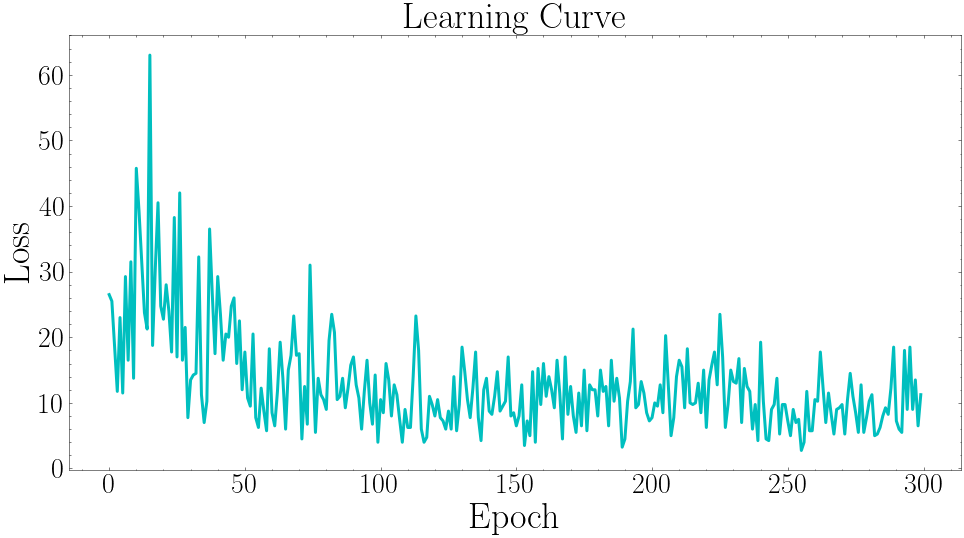

In [57]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(loss_log, color="c", lw=3)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.show()

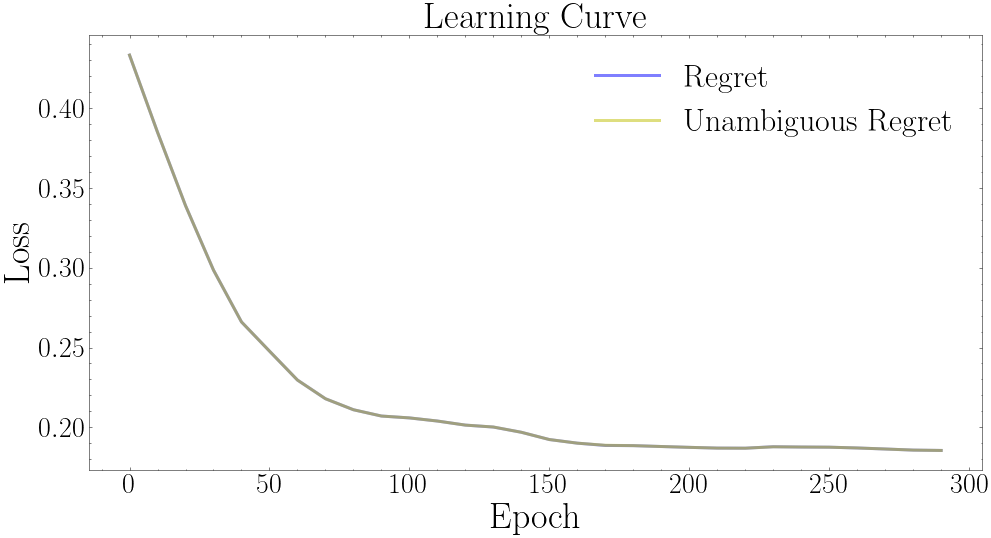

In [58]:
# draw plot
plt.figure(figsize=(16, 8))
plt.plot(range(0, num_epochs, 10), loss_log_truespo, color="b", alpha=0.5, lw=3, label="Regret")
plt.plot(range(0, num_epochs, 10), loss_log_unambspo, color="y", alpha=0.5, lw=3, label="Unambiguous Regret")
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xlabel("Epoch", fontsize=36)
plt.ylabel("Loss", fontsize=36)
plt.title("Learning Curve", fontsize=36)
plt.legend(fontsize=32)
plt.show()

In [59]:
# evaluate
spoloss = pyepo.metric.regret(reg, ks_model, ks_loader_test)
print("Normalized true SPO Loss: {:.2f}%".format(spoloss * 100))
spoloss = pyepo.metric.unambRegret(reg, ks_model, ks_loader_test)
print("Normalized unambiguous SPO Loss: {:.2f}%".format(spoloss * 100))

Normalized true SPO Loss: 18.56%
Normalized unambiguous SPO Loss: 18.56%


In [60]:
reg.eval()
# compare solutions
for i, data in enumerate(ks_loader_test):
    # load data
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # predict
    cp = reg(x)
    # convert to numpy
    x = x.to("cpu").detach().numpy()
    c = c.to("cpu").detach().numpy()
    w = w.to("cpu").detach().numpy()
    z = z.to("cpu").detach().numpy()
    cp = cp.to("cpu").detach().numpy()
    for j in range(min(10, batch_size)):
        print("Sample {}:".format(j))
        print("    True cost:", ", ".join(["{:.2f}".format(cost) for cost in c[j]]))
        print("    Pred cost:", ", ".join(["{:.2f}".format(cost) for cost in cp[j]]))
        # solve cost from prediction
        ks_model.setObj(cp[j])
        wpj, _ = ks_model.solve()
        zpj = np.dot(c[j], wpj)
        print("    True sol: " + ", ".join(["{:.0f}".format(x) for x in w[j]]) + ", True obj: {:.2f}".format(z[j,0]))
        print("    Pred sol: "+  ", ".join(["{:.0f}".format(x) for x in wpj]) + ", Pred obj: {:.2f}".format(zpj))
        print()
    break

Sample 0:
    True cost: 2.00, 4.00, 1.00, 1.00, 2.00, 1.00, 2.00, 1.00, 1.00, 2.00, 5.00, 1.00, 1.00, 5.00, 3.00, 2.00, 1.00, 2.00, 3.00, 3.00, 1.00, 1.00, 1.00, 1.00, 3.00, 3.00, 2.00, 2.00, 1.00, 2.00, 2.00, 2.00, 3.00, 1.00, 4.00, 2.00, 1.00, 3.00, 4.00, 1.00, 2.00, 4.00, 1.00, 2.00, 3.00, 1.00, 5.00, 2.00
    Pred cost: -1.33, -0.45, -3.73, -0.17, -0.26, -0.06, -1.28, -0.04, 0.31, -0.58, 10.78, -1.64, -0.23, 10.14, 5.73, -3.00, 0.23, -4.00, 6.35, -0.22, -0.01, -0.83, -0.00, 1.59, 0.53, 4.44, 1.86, 6.05, -0.34, -0.06, -0.05, -0.15, -0.07, -0.09, 2.38, 7.28, -0.78, 2.64, -0.37, -1.14, 0.66, 5.88, 0.09, -0.23, -0.64, -0.08, 11.02, -2.65
    True sol: -0, -0, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, -0, -0, -0, -0, -0, -0, -0, 1, -0, -0, -0, -0, 1, -0, True obj: 27.00
    Pred sol: 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1